In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd
#import cv2, gc
import gc
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, InputLayer
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.backend import clear_session
import tensorflow as tf

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

In [3]:
input_size = 128
epochs = 10
dropout_rate = 0.5
batch_size = 128
shape = (input_size, input_size, 3)
path = '../input/planets-dataset/planet/planet/'
train_path = '../input/planets-dataset/planet/planet/train-jpg'
test_path = '../input/planets-dataset/planet/planet/test-jpg'
lr = 0.0001
reg_str = 0.01 # Regularization Strength
nfolds = 2 # No of folds for cross validation
workers = 4 # Multithreading no of threads
maxq = 10 # Max Queue size for multithreading
tresh = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.


In [4]:
df_train = pd.read_csv(f'{path}train_classes.csv')
df_test = pd.read_csv(f'{path}sample_submission.csv')

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print(df_test.head())

X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))

y_train = np.array(df_train['tags'].tolist())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road
   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


In [5]:
labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


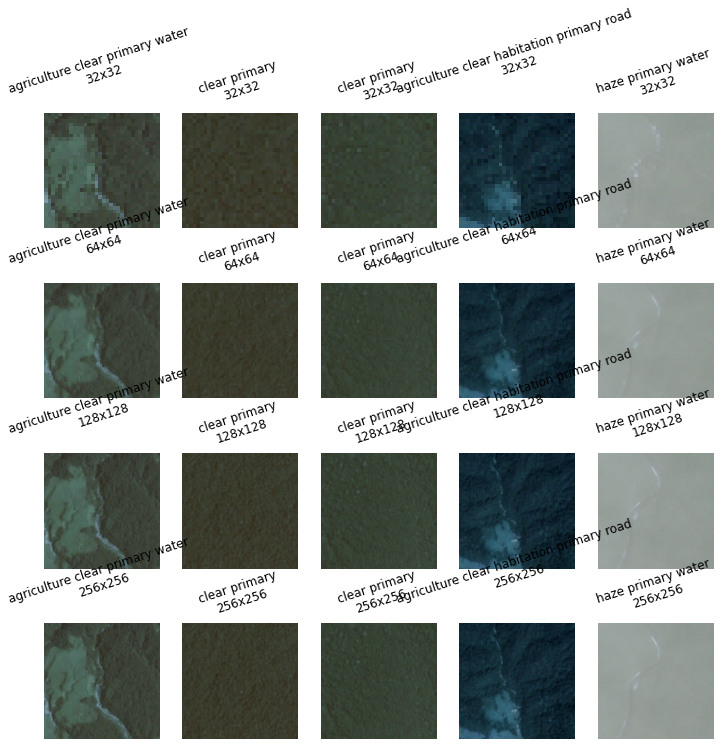

In [6]:
plt.figure(figsize=(12, 12))
res = [32, 64, 128, 256]
NIMGS = 5

for i in range(len(res)):
    for j in range(NIMGS):
        img = cv2.imread(os.path.join(train_path,df_train['image_name'][j+1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
        plt.imshow(img)
        plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]), rotation=18)
        plt.axis('off')
    
plt.show()

conventional_mine is tagged least no of times: 99
primary is tagged max no of times: 37512


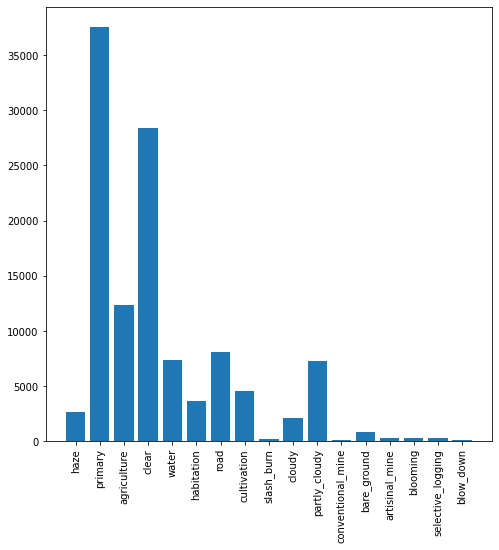

In [7]:
plt.figure(figsize=(8, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)
print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [8]:
def create_model():
    model = Sequential()
    model.add(InputLayer(shape))
    model.add(VGG16(weights='imagenet', include_top=False))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(17, activation='sigmoid'))
    return model

clear_session()

model = create_model()
model.summary()

2021-10-20 11:16:24.436323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 11:16:24.532825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 11:16:24.533565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 11:16:24.534631: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              33558528  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________

In [9]:
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [10]:
num_fold = 0

y_test = []
y_test2 = []

folds = KFold(n_splits=nfolds, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=train_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=train_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=test_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
    )
    
    test_datagen2 = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator2 = test_datagen2.flow_from_dataframe(
        df_test,
        directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional",
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
    )


    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks,
                       workers=workers, use_multiprocessing=True, max_queue_size=maxq)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=workers, use_multiprocessing=True, max_queue_size=maxq)
    y_test.append(p_test)
    
    p_test2 = model.predict_generator(test_generator2, workers=workers, use_multiprocessing=True, max_queue_size=maxq)
    y_test2.append(p_test2)
    

Found 20239 validated image filenames belonging to 17 classes.
Found 20240 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 20522 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 40669 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 40669 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 20522 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-20 11:17:26.910181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-10-20 11:17:32.291855: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


159/159 [==============================] - 189s 1s/step - loss: 0.2151 - f2_score: 0.6983 - val_loss: 0.1546 - val_f2_score: 0.8038
Epoch 2/10
159/159 [==============================] - 159s 988ms/step - loss: 0.1607 - f2_score: 0.7902 - val_loss: 0.1467 - val_f2_score: 0.8278
Epoch 3/10
159/159 [==============================] - 160s 990ms/step - loss: 0.1422 - f2_score: 0.8230 - val_loss: 0.1235 - val_f2_score: 0.8681
Epoch 4/10
159/159 [==============================] - 158s 977ms/step - loss: 0.1314 - f2_score: 0.8441 - val_loss: 0.1172 - val_f2_score: 0.8825
Epoch 5/10
159/159 [==============================] - 164s 1s/step - loss: 0.1227 - f2_score: 0.8583 - val_loss: 0.1205 - val_f2_score: 0.8827
Epoch 6/10
159/159 [==============================] - 160s 987ms/step - loss: 0.1191 - f2_score: 0.8628 - val_loss: 0.1075 - val_f2_score: 0.8921
Epoch 7/10
159/159 [==============================] - 163s 1s/step - loss: 0.1156 - f2_score: 0.8686 - val_loss: 0.1058 - val_f2_score: 0.890

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 20240 validated image filenames belonging to 17 classes.
Found 20239 validated image filenames belonging to 17 classes.
Found 40669 validated image filenames belonging to 17 classes.
Found 20522 validated image filenames belonging to 17 classes.
Epoch 1/10
159/159 [==============================] - 161s 993ms/step - loss: 0.2118 - f2_score: 0.7005 - val_loss: 0.1609 - val_f2_score: 0.8043
Epoch 2/10
159/159 [==============================] - 163s 1s/step - loss: 0.1533 - f2_score: 0.8011 - val_loss: 0.1453 - val_f2_score: 0.8277
Epoch 3/10
159/159 [==============================] - 159s 975ms/step - loss: 0.1372 - f2_score: 0.8278 - val_loss: 0.1230 - val_f2_score: 0.8708
Epoch 4/10
159/159 [==============================] - 162s 995ms/step - loss: 0.1260 - f2_score: 0.8507 - val_loss: 0.1190 - val_f2_score: 0.8719
Epoch 5/10
159/159 [==============================] - 162s 1s/step - loss: 0.1196 - f2_score: 0.8596 - val_loss: 0.1137 - val_f2_score: 0.8867
Epoch 6/10
159/159 [====

In [11]:
result1 = np.array(y_test[0])
for i in range(1, nfolds):
    result1 += np.array(y_test[i])
result1 /= nfolds
result1 = pd.DataFrame(result1, columns = labels)
result1.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.002570,0.000026,0.000219,0.022175,0.001831,0.994299,0.000109,0.000020,0.002606,0.000712,0.001516,0.006199,0.999871,0.001835,0.001375,0.000065,0.002349
1,0.016257,0.000147,0.001204,0.050317,0.008654,0.989529,0.000208,0.000115,0.022413,0.002538,0.001317,0.016432,0.999810,0.004097,0.006128,0.000695,0.005650
2,0.059326,0.000919,0.003439,0.003148,0.003212,0.003004,0.006310,0.000833,0.039260,0.003686,0.001210,0.993669,0.994543,0.019006,0.004205,0.002399,0.055923
3,0.598430,0.001162,0.031785,0.012962,0.026399,0.940230,0.000500,0.000761,0.765293,0.024038,0.008245,0.068516,0.999226,0.019595,0.009909,0.037200,0.035660
4,0.055699,0.001657,0.003127,0.001181,0.001449,0.002769,0.634718,0.001495,0.012492,0.004735,0.011397,0.570695,0.410733,0.022520,0.001351,0.001186,0.061927


In [12]:
result2 = np.array(y_test2[0])
for i in range(1, nfolds):
    result2 += np.array(y_test2[i])
result2 /= nfolds
result2 = pd.DataFrame(result2, columns = labels)
result2.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.012673,0.000285,0.001719,0.126611,0.011835,0.995176,0.000228,0.000140,0.020185,0.003294,0.000634,0.007593,0.999762,0.008058,0.019607,0.000699,0.007428
1,0.970027,0.000662,0.016998,0.000560,0.001585,0.018992,0.001468,0.003248,0.319379,0.128215,0.003635,0.988240,0.989222,0.462743,0.001598,0.011119,0.056430
2,0.592808,0.004266,0.015968,0.001741,0.001661,0.296521,0.028462,0.010788,0.126890,0.174716,0.502313,0.165051,0.892547,0.883605,0.004883,0.005200,0.655780
3,0.124622,0.001816,0.017963,0.001930,0.001919,0.982880,0.000673,0.000758,0.056326,0.016261,0.008721,0.009999,0.996882,0.143479,0.005373,0.001740,0.901890
4,0.073633,0.000127,0.003408,0.026594,0.011688,0.995054,0.000158,0.000086,0.100599,0.002695,0.001354,0.005942,0.999773,0.005834,0.004580,0.001278,0.009168


In [13]:
results = result1.append(result2, ignore_index=True)
results.shape

(61191, 17)

In [14]:
preds = []
for i in range(results.shape[0]):
    a = results.iloc[[i]]
    a = a.apply(lambda x: x > tresh, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))


In [15]:
preds[:10]

['clear primary',
 'clear primary',
 'partly_cloudy primary',
 'agriculture clear cultivation primary',
 'cloudy partly_cloudy primary',
 'clear primary',
 'agriculture clear cultivation habitation primary road',
 'clear habitation primary road',
 'clear primary',
 'agriculture clear cultivation haze primary']

In [16]:
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.head()

,image_name,tags
0,test_0,"[primary, clear, agriculture, road, water]"
1,test_1,"[primary, clear, agriculture, road, water]"
2,test_2,"[primary, clear, agriculture, road, water]"
3,test_3,"[primary, clear, agriculture, road, water]"
4,test_4,"[primary, clear, agriculture, road, water]"


In [17]:
df_test['tags'] = preds

In [18]:
fin = pd.DataFrame(df_test["image_name"])
fin.head()

,image_name
0,test_0
1,test_1
2,test_2
3,test_3
4,test_4


In [19]:
fin["tags"] = preds
fin.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear cultivation primary
4,test_4,cloudy partly_cloudy primary


In [20]:
fin.to_csv('Sayak_submission.csv', index=False)